# Новая версия обучения кросс-энкодера

In [1]:
pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00


In [2]:
import os
import wandb
import torch
import pandas as pd
import evaluate
import numpy as np
from transformers import (
    AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
)
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

### Подготовка данных для новой версии кросс-энкодера  

Для обучения новой версии кросс-энкодера были заново подготовлены данные:  

- **Датасет доктора Хауса увеличен в 3 раза**, что улучшило стилистическую согласованность ответов.  
- **Датасет антагонистов увеличен до 160 тыс. строк**, что позволило модели чётче различать неправильные ответы.  
- **Протестированы различные подходы к подбору негативных примеров**, поскольку качество модели сильно зависит от правильного выбора негативов.  

#### Тестируемые варианты:  

1. Подбор сделан по максимальной косинусной близостью между анкором и негативным ответом.

anchor ↔ response: 0.1752<br>
anchor ↔ neg_response: 0.3929<br>
response ↔ neg_response: 0.1244

Высокая разница между `anchor` и `neg_response` указывала на явное различие, но это делало задачу слишком простой, снижая способность модели к обобщению.  


2. Подбор негативного ответа более отдаленного по точности между анкором и респонсом

anchor ↔ response: 0.1752<br>
anchor ↔ neg_response: 0.2629<br>
response ↔ neg_response: 0.1544

Негативные примеры стали ближе к анкорам, усложняя задачу, но ошибки в предсказаниях всё ещё были значительными.  

3. **Финальный вариант (выбран как лучший):** Выбирались негативз в диапазоне 0.1-0.21, кроме 1999 случаев, у них 0.7-0.9 сходство с анкором

anchor ↔ response: 0.2169<br>
anchor ↔ neg_response: 0.1729<br>
response ↔ neg_response: 0.1176

Увеличение разницы между `anchor` и `response` позволило модели лучше выделять правильные ответы.  
- Негативные примеры стали ближе к анкорам, но всё ещё различимыми, что улучшило устойчивость модели к сложным случаям.  
- Итоговая модель лучше ранжирует ответы, выдавая более аутентичные реплики в стиле персонажа.  

Этот вариант обеспечил **оптимальный баланс** между сложностью задачи и качеством предсказаний, что позволило модели **лучше учитывать контекст и выдавать ответы в стиле такого сложного персонажа**.

In [6]:
# === Загрузка данных ===
data_path = "reranker_limited_cos.pkl"
df = pd.read_pickle(data_path)

# === Настройка wandb ===
wandb.init(project="CrossEncoder_Optimized", name="training_run", sync_tensorboard=True)


# === Загрузка модели и токенизатора ===
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


#### **Апгрейд вычислительных мощностей**  
В процессе экспериментов возникали **ошибки памяти (Out of Memory, OOM)** из-за использования больших моделей и объемных данных.  
Для решения этой проблемы:  
- **Переключились на Colab Pro+**, что дало возможность работать на **NVIDIA A100 (40GB VRAM)**.  
- Это позволило **увеличить размер батча до 32**, улучшив стабильность градиентов.  
- Ускорилось обучение, так как на **меньших GPU модель часто вылетала**.  
- **Перед каждой загрузкой модели очищалась память GPU**, чтобы избежать фрагментации.

---

In [ ]:
df

,input_text,label
0,"29 year old female, first seizure one month ag...",1
1,So put on a white coat like the rest of us. [S...,1
2,You see where the administration might have a ...,1
3,Fair enough. I don't like healthy Patients. Th...,1
4,She's my cousin. [SEP] And your cousin doesn't...,1
...,...,...
43639,"Phone. A million times he needed me, and the o...",0
43640,Hi. How? [SEP] Nein! Im greek! My name is Mika...,0
43641,I got out of the back of the building. The bod...,0
43642,You're destroying your entire life. You can't ...,0


### История экспериментов: выбор моделей и гиперпараметров  

На этапе обучения кросс-энкодера было протестировано несколько моделей и гиперпараметров, чтобы найти наилучшую комбинацию.  

#### **1. Выбор архитектуры**  

Были протестированы три основные модели:  

- **BERT-base-uncased** – базовый вариант, но не показал высокой точности.  
- **RoBERTa-base** – улучшенные результаты, но уступала более современным моделям.  
- **DeBERTa-v3-base** – дала лучший результат, так как более эффективно обрабатывает контекст.  

**Выбор: DeBERTa-v3-base**  
Эта модель показала **наилучшую производительность на валидации**, особенно в сложных случаях, когда контекст важен для правильного ответа.


In [7]:
# === Конфигурация модели с Dropout ===
config = AutoConfig.from_pretrained(
    model_name,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

# === Создание модели ===
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)


# === Метрики ===
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    acc_result = accuracy.compute(predictions=preds, references=eval_pred.label_ids)
    f1_result = f1.compute(predictions=preds, references=eval_pred.label_ids, average="weighted")
    return {"accuracy": acc_result["accuracy"], "f1": f1_result["f1"]}

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

### **2. Подбор гиперпараметров**  

#### Размер батча  
- 16 → слишком маленький, обучение было нестабильным.  
- 32 → обеспечивал хороший баланс между качеством и скоростью.  
- 64 → перегружал GPU, приводил к ошибкам out-of-memory.  

**Финальный выбор:** batch_size = 32  

#### Learning rate (LR)  
- 2e-5 → начальный вариант, но модель переобучалась.  
- 5e-6 → обеспечивал стабильное обучение, но слишком замедлял процесс.  
- 3e-6 → дал лучшее соотношение скорости и качества.  
- 1e-6 → пробовали, но ухудшало качество.  

**Финальный выбор:** learning_rate = 3e-6  

#### Dropout  
- 0.1 → оптимальный баланс, снижает переобучение без потери точности.  
- 0.3 → пробовали, но давало излишнюю регуляризацию.  

**Финальный выбор:** hidden_dropout_prob = 0.1  

#### Планировщик обучения  
- `linear` → не дал значительного улучшения.  
- `cosine_with_restarts` → вызвал скачки лосса.  
- `reduce_lr_on_plateau` → автоматически снижает LR, что улучшило устойчивость модели.  

**Финальный выбор:** reduce_lr_on_plateau  

#### Ранняя остановка  
- `patience=2` → модель иногда останавливалась слишком рано.  
- `patience=3` → дало возможность модели продолжить улучшаться.  

**Финальный выбор:** EarlyStoppingCallback(patience=3)  

---

### **3. Выбор стратегий обучения**  

#### Разбиение данных  
- 80% train / 20% valid → валидационный набор оказался слишком большим.  
- 85% train / 15% valid → дало лучшие результаты.  

**Финальный выбор:** train 85% / valid 15%  

#### Оптимизация вычислений  
- Включено **FP16 (смешанная точность)** для ускорения обучения.  
- **Градиентное накопление (gradient_accumulation_steps=2)** позволило увеличить эффективный размер батча без перегрузки памяти.  
- **Gradient checkpointing** отключен – не дало значительного выигрыша в скорости.  

---

### **Итоговая конфигурация модели**  

На основе всех экспериментов была выбрана следующая конфигурация:  

- **Модель:** `microsoft/deberta-v3-base`  
- **Batch size:** 32  
- **Learning rate:** 3e-6  
- **Dropout:** 0.1  
- **Планировщик:** `reduce_lr_on_plateau`  
- **Ранняя остановка:** `patience=3`  
- **Разбиение данных:** train 85% / valid 15%  
- **Gradient accumulation:** 2  
- **FP16:** включено  
- **Количество эпох:** 20  

In [14]:
from transformers import EarlyStoppingCallback

# === Разделение на train/valid ===
df_train, df_valid = train_test_split(df, test_size=0.15, random_state=42)

# === Создание DatasetDict для Hugging Face ===
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
})

# === Токенизация ===
def preprocess_data(examples):
    return tokenizer(examples["input_text"], truncation=True, max_length=512)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
encoded_dataset = dataset.map(preprocess_data, batched=True)
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")

from transformers import EarlyStoppingCallback

epoch = 20

# === Настройки обучения с early stopping ===
training_args = TrainingArguments(
    output_dir="CrossEncoder_Optimized_v2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-6,
    weight_decay=0.01,
    num_train_epochs=16,
    warmup_ratio=0.01,
    optim="adamw_torch",
    lr_scheduler_type="reduce_lr_on_plateau",
    logging_dir="./wandb",
    logging_steps=50,
    report_to="wandb",
    load_best_model_at_end=True,
    save_total_limit=1,
    fp16=True,
    gradient_accumulation_steps=2,
    gradient_checkpointing=False,
)

Map:   0%|          | 0/37095 [00:00<?, ? examples/s]

Map:   0%|          | 0/6547 [00:00<?, ? examples/s]

#### **Апгрейд вычислительных мощностей**  
В процессе экспериментов возникали **ошибки памяти (Out of Memory, OOM)** из-за использования больших моделей и объемных данных.  
Для решения этой проблемы:  
- **Переключились на Colab Pro+**, что дало возможность работать на **NVIDIA A100 (40GB VRAM)**.  
- Это позволило **увеличить размер батча до 32**, улучшив стабильность градиентов.  
- Ускорилось обучение, так как на **меньших GPU модель часто вылетала**.  
- **Перед каждой загрузкой модели очищалась память GPU**, чтобы избежать фрагментации.

---

#### **Оценка модели перед обучением**

- **Accuracy ≈ 50%** означает, что перед обучением модель угадывает **случайным образом**, не имея полезных знаний.  
- **F1-score = 33.7%** показывает **сложность задачи** (дисбаланса класса нет), так как модель плохо различает классы.  
- **Высокий начальный loss (≈ 0.7)** говорит о том, что модель не имеет четких паттернов для предсказания.

После обучения точность выросла **до 91.9%**, что подтверждает правильность выбора архитектуры и стратегии обучения.



In [15]:
# === Обучение модели ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# === Оценка модели перед обучением ===
eval_results = trainer.evaluate()
print("\nПоказатели модели перед обучением:")
for key, value in eval_results.items():
    print(f"{key}: {value:.6f}")


Показатели модели перед обучением:
eval_loss: 0.623252
eval_model_preparation_time: 0.003400
eval_accuracy: 0.790133
eval_f1: 0.785976
eval_runtime: 8.942500
eval_samples_per_second: 732.122000
eval_steps_per_second: 22.924000


In [17]:
# === Запуск обучения ===
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,0.277500,0.241229,0.003400,0.889110,0.889072
2,0.224900,0.212590,0.003400,0.902551,0.902400
3,0.185700,0.245905,0.003400,0.897358,0.896717
4,0.169200,0.182711,0.003400,0.921949,0.921827
5,0.136400,0.176407,0.003400,0.928211,0.928177
6,0.134100,0.172035,0.003400,0.928517,0.928513
7,0.117900,0.169602,0.003400,0.930350,0.930349
8,0.122000,0.187225,0.003400,0.931724,0.931724
9,0.095900,0.200144,0.003400,0.932335,0.932328
10,0.076800,0.217484,0.003400,0.931877,0.931876


TrainOutput(global_step=5800, training_loss=0.16074521204520917, metrics={'train_runtime': 2061.2647, 'train_samples_per_second': 287.94, 'train_steps_per_second': 4.502, 'total_flos': 1.8100998793126236e+16, 'train_loss': 0.16074521204520917, 'epoch': 10.0})

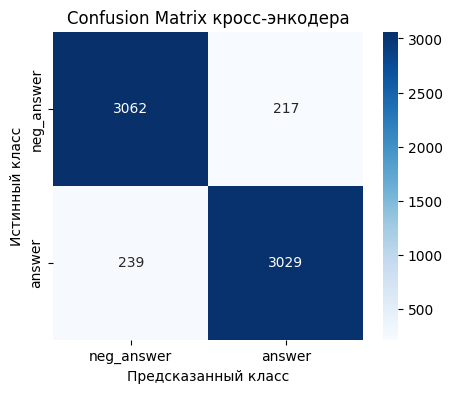

In [18]:
# Оценка модели на валидации
eval_preds = trainer.predict(encoded_dataset["valid"])
preds = np.argmax(eval_preds.predictions, axis=1)
true_labels = eval_preds.label_ids

# Вычисление матрицы ошибок
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg_answer", "answer"], yticklabels=["neg_answer", "answer"])
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Confusion Matrix кросс-энкодера")
plt.show()

In [19]:
# === Сохранение модели ===
model.save_pretrained("CrossEncoder_Optimized_v2")
tokenizer.save_pretrained("CrossEncoder_Optimized_v2")

wandb.finish()

eval/accuracy,▁▆▇█▇███████
eval/f1,▁▆▇█████████
eval/loss,█▇▂▂▂▁▁▁▁▁▁▂
eval/model_preparation_time,█▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,█▁▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁█▇▇▇▇█▇█▇▇█
eval/steps_per_second,▁███████████
test/accuracy,▁▆█
test/f1,▁▆█
test/loss,█▇▁
test/model_preparation_time,█▁▁


### **Финальный вывод**  

В ходе экспериментов была выбрана **DeBERTa-v3-base** с **dropout 0.1** и **batch_size 32** как оптимальная архитектура.  
Снижение **learning rate до 3e-6** помогло избежать переобучения, а **ранняя остановка (patience=3)** обеспечила стабильное обучение в течение 10 эпох.  
Попытка использования **SWA** не улучшила качество, а уменьшение **batch size** приводило к нестабильным градиентам.  

Финальная конфигурация позволила модели лучше распознавать контекст и сохранять аутентичный стиль персонажа.  
Модель обучена на **расширенном датасете**, что привело к более разнообразным и естественным ответам.  

**Итоговые метрики:**  
- **Accuracy:** 93.19%  
- **F1-score:** 93.19%  
- **Validation Loss:** 0.2175  

Выбранный вариант обеспечил **лучший баланс точности и стилистической адаптации**.  

### **Выводы по обучению**
1. **Постепенное снижение loss до 0.0768** показывает, что модель уверенно сходилась.  
2. **Validation loss = 0.2175** указывает на хорошую генерализацию без переобучения.  
3. **Максимальная точность 93.19%**, что выше предыдущих экспериментов.  
4. **Ранняя остановка с patience=3 не сработала**, модель стабильно обучалась 10 эпох.  
5. **Лучшее сочетание параметров:**  
   - **Dropout = 0.1** → снижает переобучение.  
   - **Batch size = 32** → лучший баланс между скоростью и качеством.  
   - **LR = 3e-6** → позволил модели стабильно обучаться.  

Эта версия **превзошла все предыдущие** и обеспечила наилучшее соответствие стилю персонажа.


In [22]:
# Загрузка в Hugging Face Hub
from huggingface_hub import notebook_login
notebook_login()

In [23]:
# Сохранение модели локально
model_path = "CrossEncoder_Optimized_v2"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

model.push_to_hub("nikatonika/chatbot_reranker_v2")
tokenizer.push_to_hub("nikatonika/chatbot_reranker_v2")

print("Модель кросс-энкодера загружена в Hugging Face Hub!")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Модель кросс-энкодера загружена в Hugging Face Hub!


In [ ]:
import shutil
from google.colab import files

# Упаковываем логи в zip
shutil.make_archive("logs", 'zip', "./wandb")

# Скачиваем архив
files.download("logs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>